## Exercise 1

 - Import Barcelona_air_pollution data
 - Find the most interessting series to predict
 - Is it stationary? Is it seasonal?
 - Predict and validate the pollution for the last 6 months
 - Use wind_speed from weather data to improve your prediction

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [11]:
air_pol = pd.read_csv('Barcelona_air_pollution.csv', sep = ';')
air_pol['date_hour0'] = air_pol['date'] + ' ' + air_pol['hour'].astype(str)
air_pol['date_hour'] = pd.to_datetime(air_pol['date_hour0'], format = '%d/%m/%Y %H')
air_pol.drop(['date','hour','date_hour0'], axis = 1, inplace = True)
air_pol.sample(5)

,lon,lat,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,aqi,year,city,date_hour
7314,41.3888,2.159,176.91,0.0,0.07,28.61,0.05,0.70,1.08,0.28,1,2021,Barcelona,2021-11-02 18:00:00
3140,41.3888,2.159,230.31,0.0,0.17,43.99,0.32,3.08,9.30,0.28,1,2021,Barcelona,2021-05-12 21:00:00
2093,41.3888,2.159,206.95,0.0,0.07,39.70,0.03,4.90,7.61,0.18,1,2021,Barcelona,2021-03-30 06:00:00
8716,41.3888,2.159,216.96,0.0,0.09,50.07,0.10,3.32,13.02,0.31,1,2021,Barcelona,2021-12-31 04:00:00
2030,41.3888,2.159,198.60,0.0,0.05,52.93,0.07,11.01,20.68,0.18,1,2021,Barcelona,2021-03-27 14:00:00


<Figure size 1200x700 with 0 Axes>

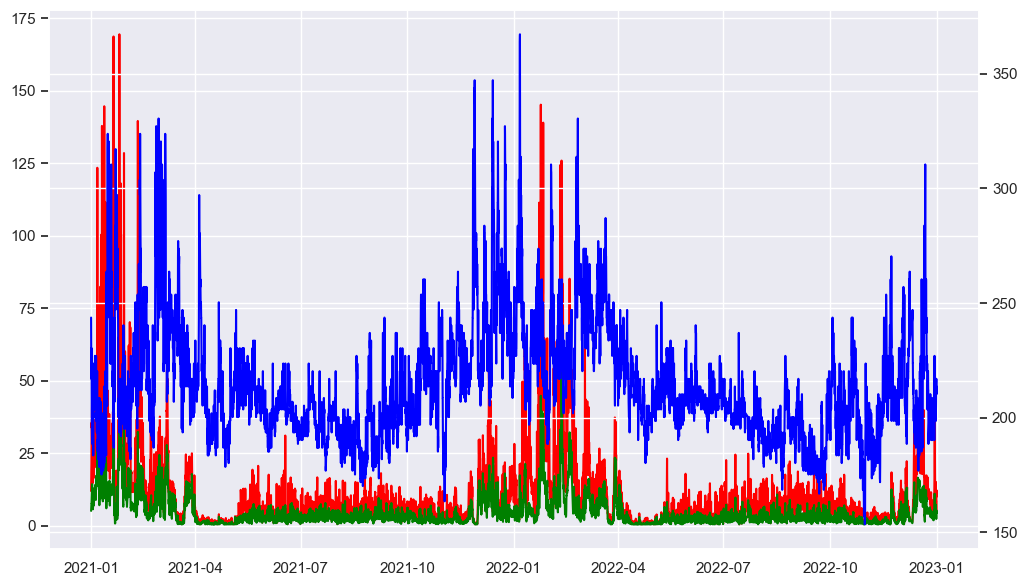

In [12]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
# sns.lineplot(data = air_pol, x = 'date_hour', y = 'CO')
# ax.plt.plot(air_pol['date_hour'], air_pol['PM10'])
# ax.plt.plot(air_pol['date_hour'], air_pol['PM2_5'])
# ax2.plt.plot(air_pol['date_hour'], air_pol['CO'])
# plt.xticks(rotation=45);

ax.plot(air_pol['date_hour'], air_pol['PM10'], color = 'red')
ax.plot(air_pol['date_hour'], air_pol['PM2_5'], color = 'green')
ax2.plot(air_pol['date_hour'], air_pol['CO'], color = 'blue')
plt.xticks(rotation=45);


### Utilizaremos la columna CO.

Esta columna nos ha parecido la más interesante para la predicción, debido a la estacionalidad y fuertes picos presentados

<Figure size 1200x700 with 0 Axes>

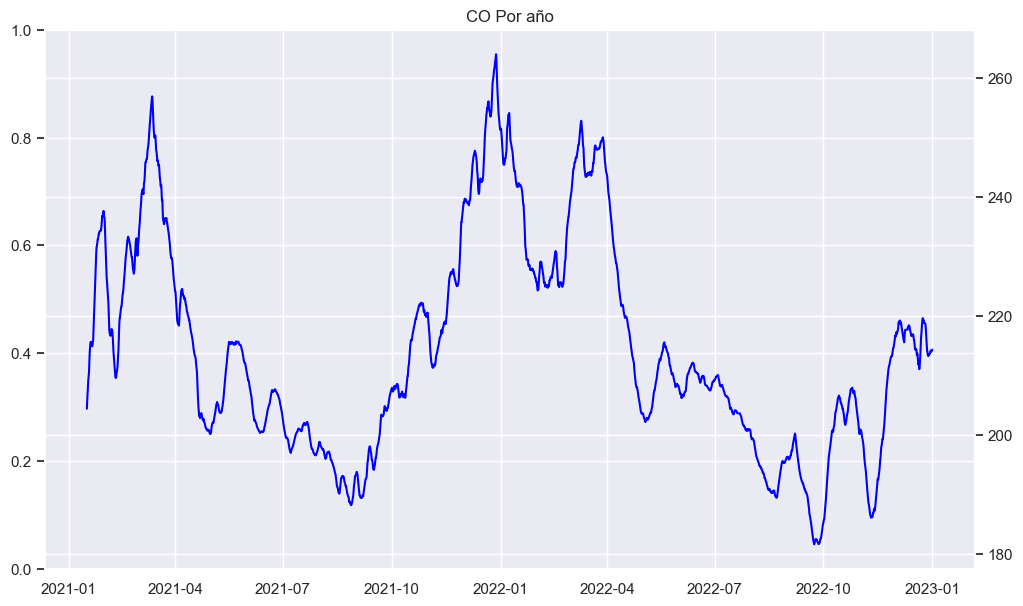

In [25]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
plt.title("CO Por año")
ax2.plot(air_pol['date_hour'], air_pol['CO'].rolling(365).mean(), color = 'blue')
plt.xticks(rotation=45);


Viendo el gráfico podemos ver que hay una estacionalidad anual, donde en los meses de inviernos hay picos, y en verano tenemos mínimos.

In [112]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

df_prophet = df[['date_hour', 'CO']]
df_prophet.columns = ['ds', 'y']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

six_months_ago = df_prophet['ds'].max() - pd.DateOffset(months=6)

df_prophet_before_six_months = df_prophet[df_prophet['ds'] < six_months_ago]
df_prophet_last_six_months = df_prophet[df_prophet['ds'] > six_months_ago]

model = Prophet(yearly_seasonality=True) 
model.fit(df_prophet_before_six_months)

future = model.make_future_dataframe(periods=180 * 24, freq = "H")  # Seis meses

forecast = model.predict(future)

08:57:00 - cmdstanpy - INFO - Chain [1] start processing
08:57:04 - cmdstanpy - INFO - Chain [1] done processing


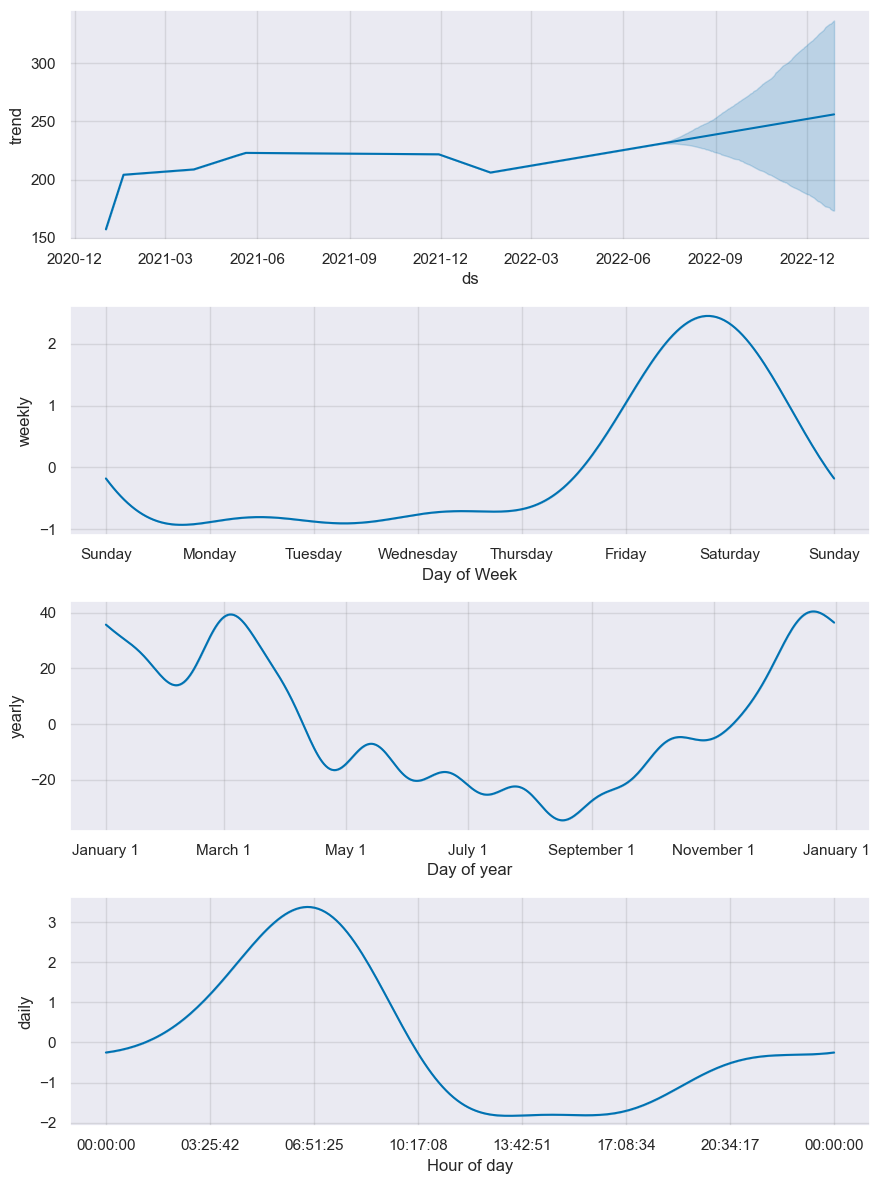

In [113]:
fig = model.plot_components(forecast)
plt.show()

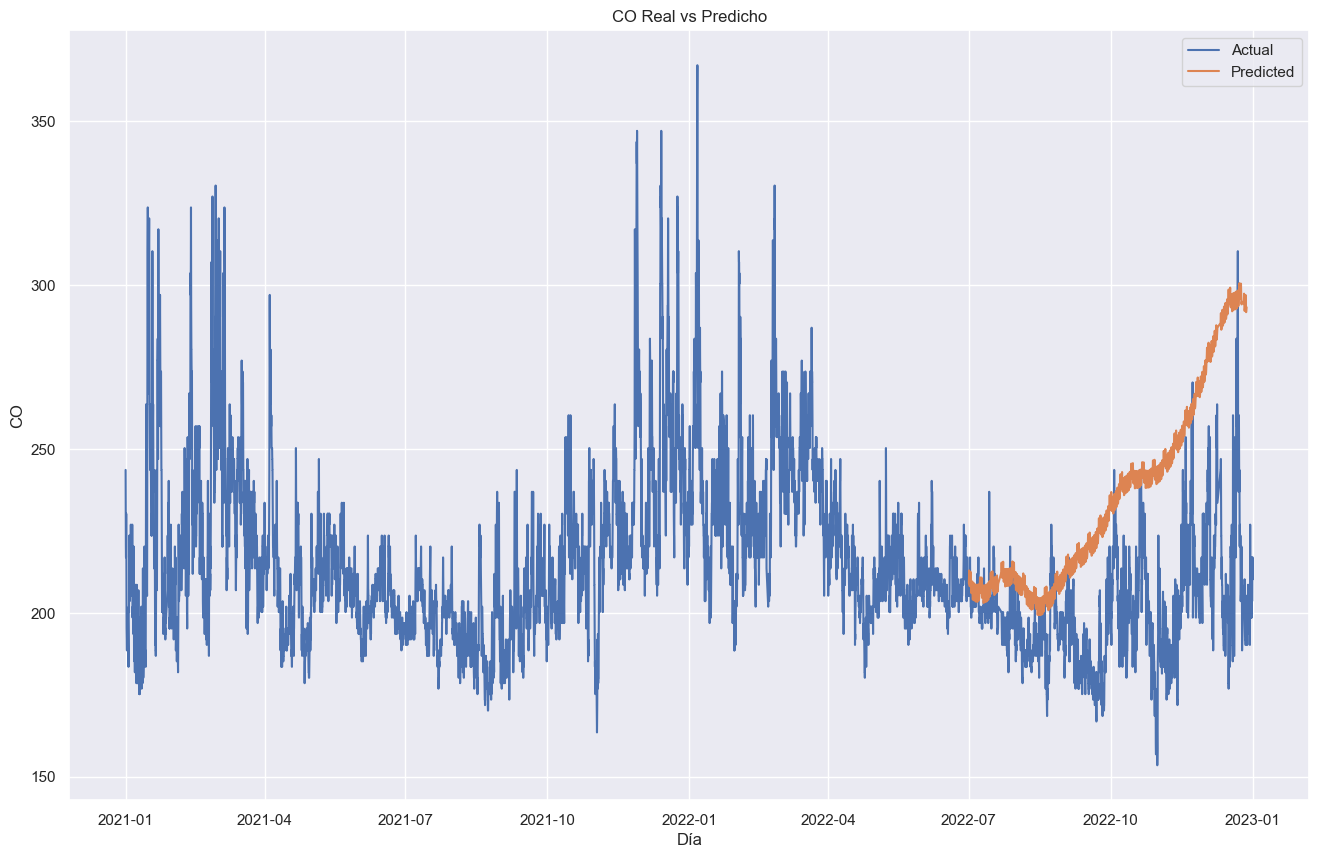

In [114]:
merged_data = pd.merge(df_prophet_last_six_months, forecast[['ds', 'yhat']], on='ds')

plt.figure(figsize=(16, 10))

plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')

plt.plot(merged_data['ds'], merged_data['yhat'], label='Predicted')
plt.xlabel('Día')
plt.ylabel('CO')
plt.title('CO Real vs Predicho')
plt.legend()
plt.show()

In [122]:
from sklearn.metrics import mean_squared_error

new_df = df_prophet_last_six_months.merge(forecast[['ds', 'yhat']], on = "ds") 

mse = mean_squared_error(new_df['y'].values, new_df['yhat'].values)

print(mse)

1848.3141066256094


Se ve que la predicción es bsatante buena y coge bien la tendencia. Aunque no es suficiente.

### Utilizar la información de viento

In [56]:
from datetime import datetime

In [57]:
format_str = "%Y-%m-%d %H:%M:%S %z %Z"

In [58]:
weather = pd.read_csv("Barcelona_weather.csv", sep = ";")

In [68]:
weather['dt_iso'] = weather['dt_iso'].apply(lambda x: x.split("+")[0].strip())

In [70]:
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])

In [77]:
air_pol = air_pol.merge(weather, left_on = "date_hour", right_on = "dt_iso")

In [78]:
air_pol

,lon_x,lat_x,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,41.3888,2.159,243.66,0.0,0.07,41.84,0.07,5.12,11.97,0.41,...,2.6,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
1,41.3888,2.159,233.65,0.0,0.08,44.35,0.07,5.52,14.40,0.38,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
2,41.3888,2.159,226.97,0.0,0.08,46.49,0.06,5.83,16.02,0.34,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,41.3888,2.159,223.64,0.0,0.08,46.49,0.06,6.08,16.92,0.30,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
4,41.3888,2.159,220.30,0.0,0.09,46.49,0.06,6.44,17.89,0.26,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17521,41.3888,2.159,216.96,0.0,0.07,40.05,0.05,2.71,5.42,0.37,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
17522,41.3888,2.159,216.96,0.0,0.07,38.98,0.05,3.10,6.23,0.40,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
17523,41.3888,2.159,213.62,0.0,0.07,41.13,0.09,4.61,9.95,0.41,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
17524,41.3888,2.159,210.29,0.0,0.06,45.06,0.11,5.32,12.26,0.36,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n


### Predicción

In [123]:
df = air_pol.copy()

df_prophet = df[['date_hour', 'CO', 'wind_speed']]
df_prophet.columns = ['ds', 'y', 'wind_speed']
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

six_months_ago = df_prophet['ds'].max() - pd.DateOffset(months=6)

df_prophet_before_six_months = df_prophet[df_prophet['ds'] < six_months_ago]
df_prophet_last_six_months = df_prophet[df_prophet['ds'] > six_months_ago]

In [124]:
model = Prophet(yearly_seasonality=True)
model.add_regressor('wind_speed')

model.fit(df_prophet_before_six_months)

09:00:08 - cmdstanpy - INFO - Chain [1] start processing
09:00:13 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
future = model.make_future_dataframe(periods=180 * 24, freq = "H")  # Seis meses
future['wind_speed'] = df_prophet['wind_speed'] 

forecast = model.predict(future)

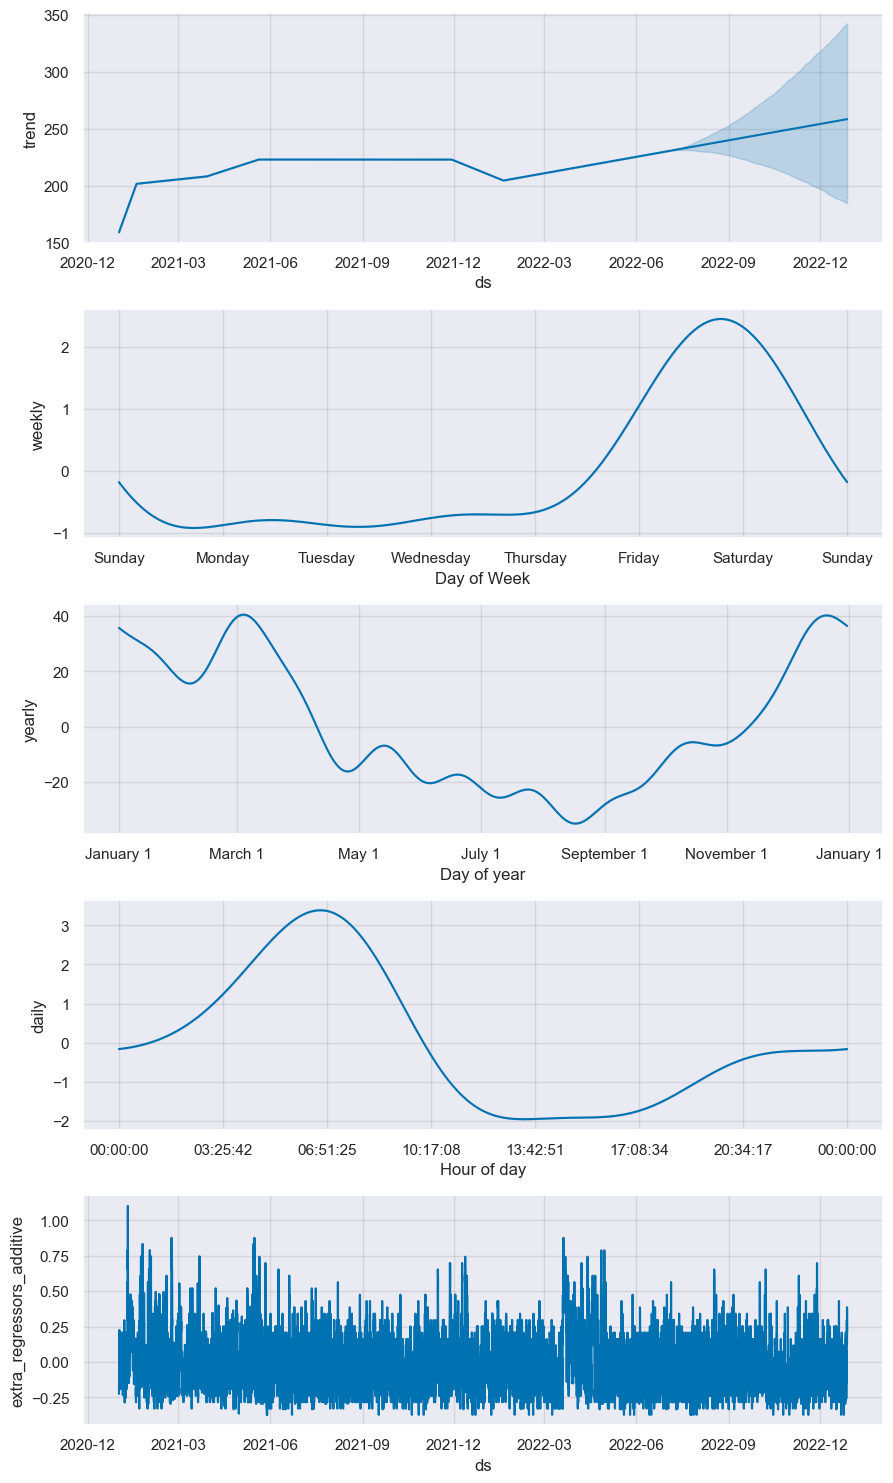

In [126]:
fig = model.plot_components(forecast)
plt.show()

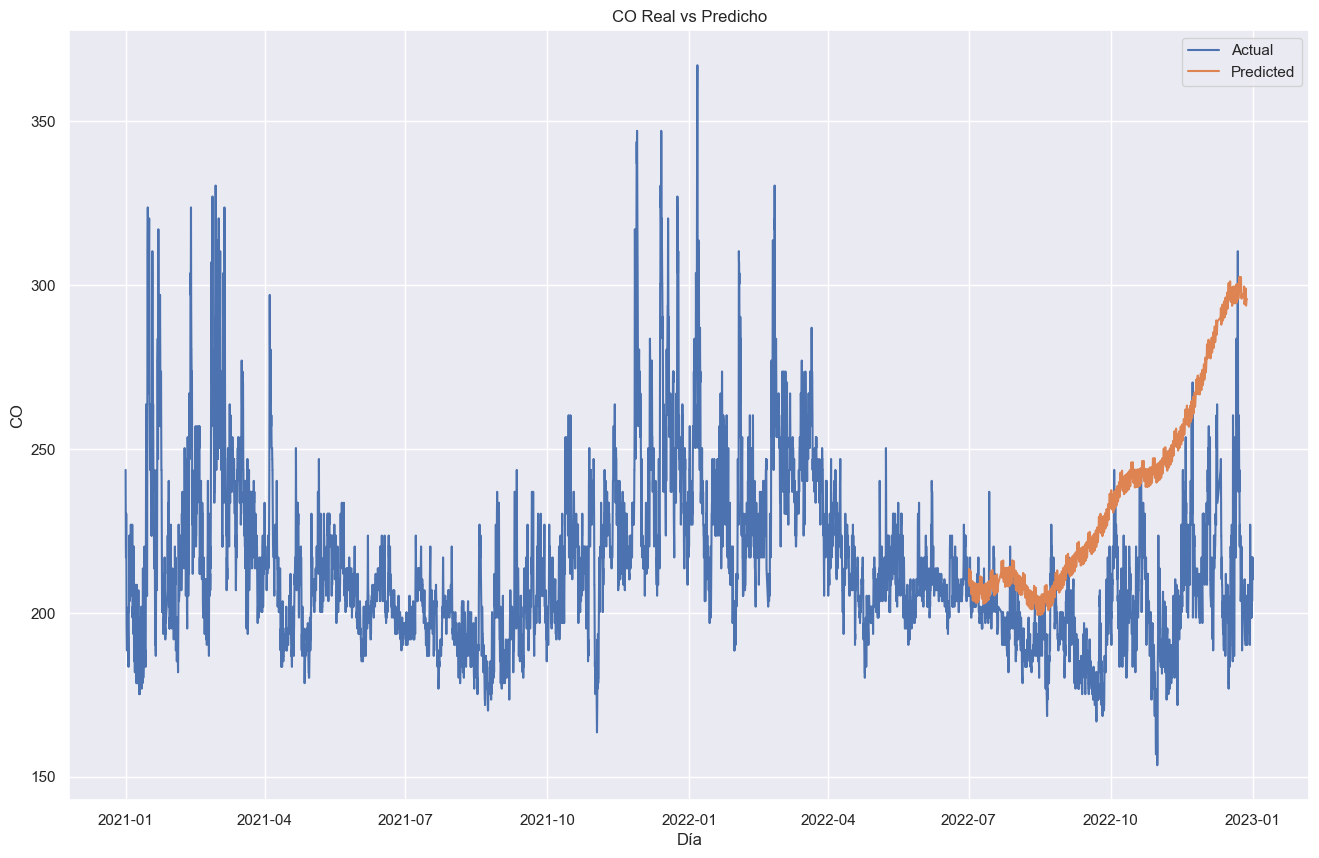

In [127]:
merged_data = pd.merge(df_prophet_last_six_months, forecast[['ds', 'yhat']], on='ds')

plt.figure(figsize=(16, 10))

plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')

plt.plot(merged_data['ds'], merged_data['yhat'], label='Predicted')
plt.xlabel('Día')
plt.ylabel('CO')
plt.title('CO Real vs Predicho')
plt.legend()
plt.show()

In [128]:
new_df = df_prophet_last_six_months.merge(forecast[['ds', 'yhat']], on = "ds") 

mse = mean_squared_error(new_df['y'].values, new_df['yhat'].values)

print(mse)

1909.1407448666453


Agregando la velocidad del viento no cambia mucho.
Seguimos con el mismo error que teníamos antes.

In [131]:
air_pol[['CO', 'wind_speed']].corr()

,CO,wind_speed
CO,1.000000,0.062617
wind_speed,0.062617,1.000000


Se ve que no hay mucha relación